<a href="https://colab.research.google.com/github/Lilchoto3/DS-Unit-1-Sprint-3-Linear-Algebra/blob/master/module4-clustering/LS_DS_134_Clustering_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-Means Clustering

# 1) Use the "Breast Cancer Wisconsin (Diagnostic) Data Set" from Kaggle to try and cluster types of cancer cells. 

Here's the original dataset for your reference:

<https://www.kaggle.com/uciml/breast-cancer-wisconsin-data>

## This is a supervised learning dataset

(Because it has **labels** - The "diagnosis" column.)

In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA # You don't necessarily have to use this
from sklearn.cluster import KMeans # You don't necessarily have to use this
from sklearn.preprocessing import StandardScaler # You don't necessarily have to use this

df = pd.read_csv("https://raw.githubusercontent.com/ryanleeallred/datasets/master/Cancer_Cells.csv")
print(df.shape)
df.head()

(569, 33)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


## Now it's an unsupervised learning dataset

(Because we've removed the diagnosis label) - Use this version.

In [166]:
df = df.drop('diagnosis', axis=1)
df = df.drop('Unnamed: 32', axis=1) # needed to add this because it was filled with NaNs.
df = df.drop('id', axis=1) # I don't need this.
print(df.shape)
df.head()

(569, 30)


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## Let's do it!

- You might want to do some data exploration to see if you can find specific columns that will help you find distinct clusters of cells
- You might want to use the elbow method to decide on the number of clusters to use.


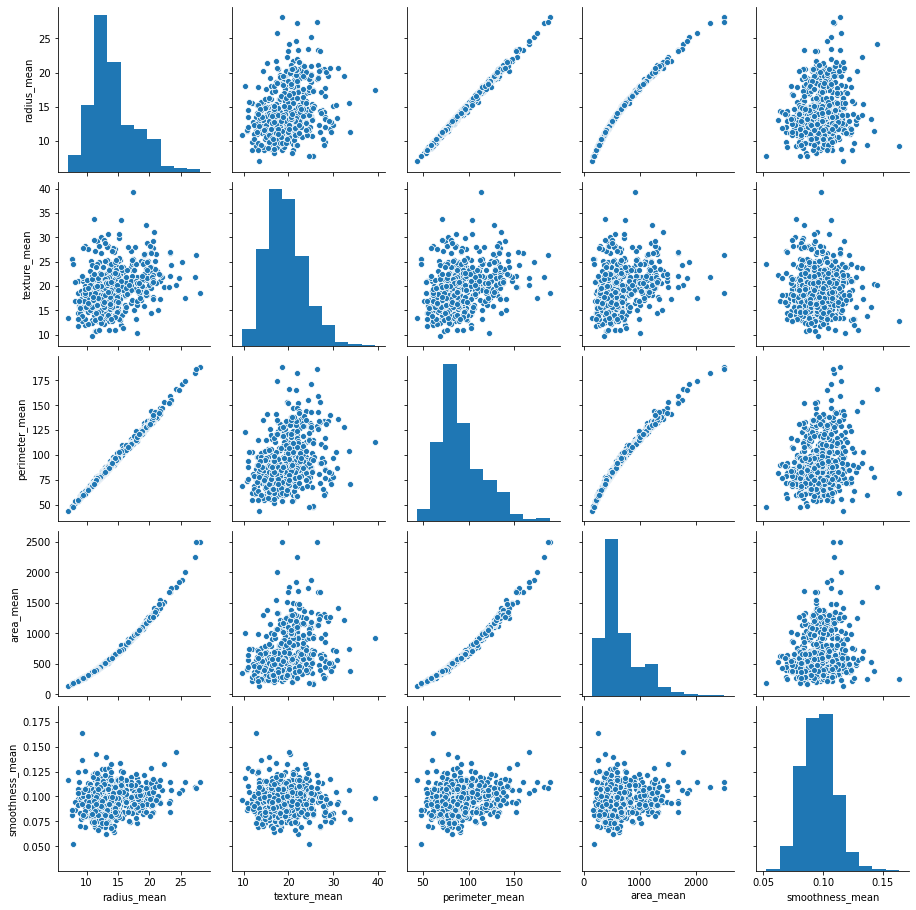

In [167]:
# I wonder how well Seaborn will handle me doing scatter plots of everything against everything else

import seaborn as sns

sns.pairplot(df[['radius_mean','texture_mean','perimeter_mean','area_mean','smoothness_mean']]);

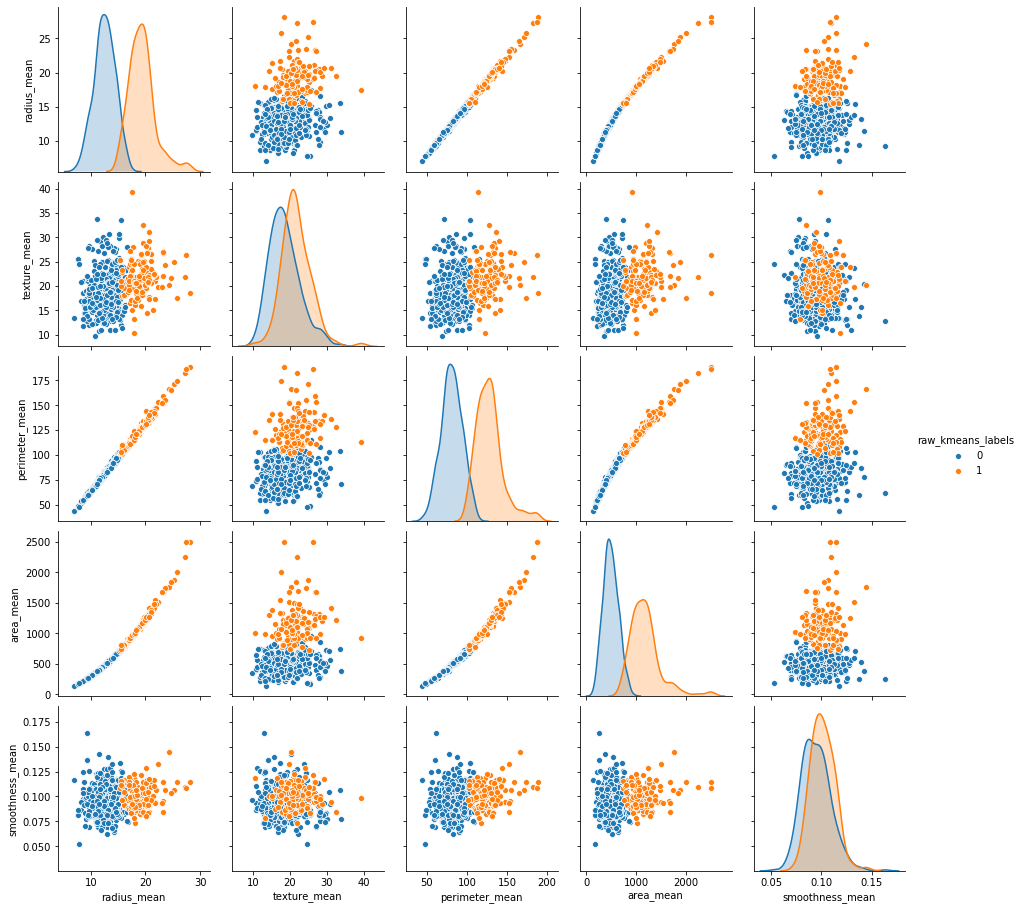

In [168]:
# Very neat

# I'm gonna do KMeans on the raw data.

kmeans = KMeans(2)
kmeans.fit(df)
df['raw_kmeans_labels'] = pd.Series(kmeans.labels_)

sns.pairplot(df[['radius_mean','texture_mean','perimeter_mean','area_mean','smoothness_mean','raw_kmeans_labels']],
             hue='raw_kmeans_labels');

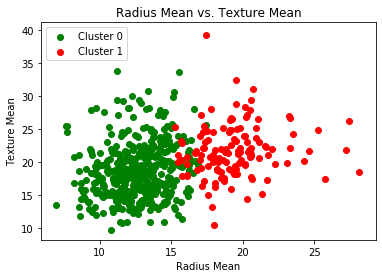

In [169]:
# So it seems like, at least with a few of the parameters, there are some obvious
# splits on the graphs of the raw data by KMeans.

# Let's make a graph of the first two for later in matplotlib
fig, ax = plt.subplots()

# Seperate the frames by label for plotting
df_0 = df[df['raw_kmeans_labels']==0]
df_1 = df[df['raw_kmeans_labels']==1]

ax.scatter(df_0['radius_mean'], df_0['texture_mean'], color='g', label='Cluster 0')
ax.scatter(df_1['radius_mean'], df_1['texture_mean'], color='r', label='Cluster 1')

ax.legend(loc='upper left')

ax.set_xlabel('Radius Mean')
ax.set_ylabel('Texture Mean')
ax.set_title('Radius Mean vs. Texture Mean')

plt.show()

## Check you work: 

This is something that in a truly unsupervised learning situation **WOULD NOT BE POSSIBLE**. But for educational purposes go back and grab the true diagnosis column (label) from the original dataset. Take your cluster labels and compare them to the original diagnosis column. You can make scatterplots for each to see how they compare or you can calculate a percent accuracy score like: 
\begin{align}
\frac{\text{Num Correct Labels}}{\text{Num Total Observations}}
\end{align}

In [170]:
# Re-load the data set to get diagnosis back
df = pd.read_csv("https://raw.githubusercontent.com/ryanleeallred/datasets/master/Cancer_Cells.csv")

# Re-remove these for later
df = df.drop('Unnamed: 32', axis=1)
df = df.drop('id', axis=1)

# re-add raw_kmeans_labels
df['raw_kmeans_labels'] = pd.Series(kmeans.labels_)

# I'm gonna pull just the diagnosis series from the earlier dataset
# First though I need to numerize it
df['diagnosis'].value_counts(dropna=False)

B    357
M    212
Name: diagnosis, dtype: int64

In [171]:
# No NaNs, lets map it
df['diagnosis'] = df['diagnosis'].map({'B':0,'M':1})

df['diagnosis'].value_counts()

0    357
1    212
Name: diagnosis, dtype: int64

In [172]:
# Save this for later
diag = df['diagnosis'].copy()

# Okay, how accurate is a raw KMeans guess
raw_accuracy = (df['diagnosis'] == df['raw_kmeans_labels']).value_counts()[1] / df.shape[0]

print('Cluster Accuracy: ',raw_accuracy)

Cluster Accuracy:  0.8541300527240774


# 2) Perform PCA on your dataset first and *then* use k-means clustering. 

- You need to standardize your data before PCA.
- First try clustering just on PC1 and PC2 so that you can make a scatterplot of your clustering.
- Then use use a scree plot to decide how many principal components to include in your clustering, and use however many principal components you need in order to retain 90% of the variation of the original dataset



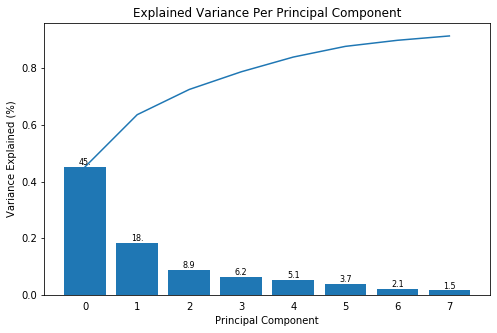

In [173]:
# I'm going to start by doing the elbow method to see how the principal components stack up

# Start by standardizing the data
scaler = StandardScaler()
Z = scaler.fit_transform(df)

# Do PCA, only the components that matter for 90% of the result
pca = PCA(.9)
pca_features = pca.fit_transform(Z)

# Make a scree plot

# Set up X values
num_compos = len(pca.explained_variance_ratio_)
ind = np.arange(num_compos)
vals = pca.explained_variance_ratio_

# Set up plot
plt.figure(figsize=(8, 5))
ax = plt.subplot(111)
cum_vals = np.cumsum(vals)
ax.bar(ind, vals)
ax.plot(ind, cum_vals)

# Put numbers on top of the bars
for i in range(num_compos):
  ax.annotate(r'%s' % ((str(vals[i]*100)[:3])), (ind[i], vals[i]), va='bottom', ha='center', fontsize=8)

# Set ticks
ax.xaxis.set_tick_params(width=0)

# Set labels
ax.set_xlabel('Principal Component')
ax.set_ylabel('Variance Explained (%)')
plt.title('Explained Variance Per Principal Component')
plt.show()

In [174]:
# I'm gonna turn pca_features into a DataFrame and then see what it looks like
pca_features = pd.DataFrame(pca_features)

# I'm also going to set up the column headers beforehand so it's easier to access
pca_features.columns = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8']

pca_features.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,9.358928,2.290827,-0.932019,-3.707943,-1.244678,1.419775,2.183242,-0.184197
1,3.050810,-3.882385,-0.501460,-1.130559,0.528175,0.016317,-0.172888,0.834906
2,6.159316,-0.963129,-0.483559,-0.949292,-0.202120,0.540155,-0.681618,0.120144
3,6.656588,10.652299,-3.296264,-0.118501,-2.959960,3.063642,1.369031,1.249136
4,4.457296,-1.961136,1.464617,-2.884858,0.358357,-1.245523,-1.121281,0.904063


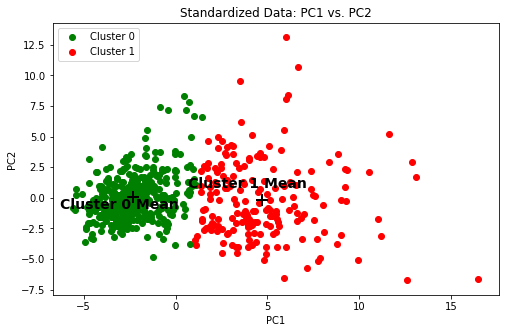

In [175]:
# Well, That certainly settles it.

# Okay, now to set up the KMeans clustering graph
# I'm gonna try starting with two clusters, since there's only one main principal component.
kmeans = KMeans(2)
kmeans.fit(pca_features)

# Add the results we get from KMeans to our pca_features for labelling in the scatter plot
pca_features['pca_labels'] = pd.Series(kmeans.labels_)

# Seperate pca_features by label
pca_f_0 = pca_features[pca_features['pca_labels']==0]
pca_f_1 = pca_features[pca_features['pca_labels']==1]

# Now graph it for PC1 and PC2
plt.figure(figsize=(8, 5))
ax = plt.subplot(111)
ax.scatter(pca_f_0['PC1'], pca_f_0['PC2'], c='g', label='Cluster 0')
ax.scatter(pca_f_1['PC1'], pca_f_1['PC2'], c='r', label='Cluster 1')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Standardized Data: PC1 vs. PC2')

# Add a legend to the plot
ax.legend(loc='upper left')

# I also want to show the centroids for each label

# Calculate the means
mean_0_PC1 = np.mean(pca_f_0['PC1'])
mean_0_PC2 = np.mean(pca_f_0['PC2'])
mean_1_PC1 = np.mean(pca_f_1['PC1'])
mean_1_PC2 = np.mean(pca_f_1['PC2'])

# Put the centroids on the plot
ax.plot(mean_0_PC1, mean_0_PC2, marker='+', color='black', markersize=12, markeredgewidth=2)
ax.plot(mean_1_PC1, mean_1_PC2, marker='+', color='black', markersize=12, markeredgewidth=2)
ax.annotate('Cluster 0 Mean', xy=(mean_0_PC1-4, mean_0_PC2-1), fontweight='bold', color='black', fontsize=14)
ax.annotate('Cluster 1 Mean', xy=(mean_1_PC1-4, mean_1_PC2+1), fontweight='bold', color='black', fontsize=14)

plt.show()

## Check your work: 

- Compare your PC1, PC2 clustering scatterplot to the clustering scatterplots you made on the raw data
- Calculate accuracy scores for both the PC1,PC2 Principal component clustering and the 90% of explained variance clustering.

How do your accuracy scores -when preprocessing the data with PCA- compare to the accuracy when simply clustering on the raw data?

In [176]:
# I'm going to just display images instead of re-coding the plots since it's easier.
# The images below are taken from runs of the code such that
# the clustering colors match up, since sometimes they swap for no reason
# so I'm using images to be consistent.
from IPython.display import display, Image
display(Image(url="https://i.imgur.com/1jLIfDs.png"))

In [177]:
display(Image(url="https://i.imgur.com/TNyedKL.png"))

In [178]:
# Now to compare my accuracy scores for pre- and post-PCA

# re-add diagnosis to the dataframe
pca_features['diagnosis'] = diag

# Print the accuracies
print('Raw Accuracy: ',raw_accuracy)
print('Accuracy After PCA: ', (pca_features['diagnosis'] == pca_features['pca_labels']).value_counts()[1] / pca_features.shape[0])

Raw Accuracy:  0.8541300527240774
Accuracy After PCA:  0.9349736379613357


# Stretch Goals:

- Study for the Sprint Challenge
- Work on your Data Storytelling Project